Experiment  Global/root-1742898658: 100%|██████████| 5/5 [00:07<00:00,  1.43s/sample]


patronus:detect-hallucination-missing-info (judge) [link_idx=0]
---------------------------------------------------------------
Count     : 5
Pass rate : 0
Mean      : 0.5
Min       : 0.5
25%       : 0.5
50%       : 0.5
75%       : 0.5
Max       : 0.5

Score distribution
Score Range          Count      Histogram
0.50 - 0.60          5          ####################
0.60 - 0.70          0          
0.70 - 0.80          0          
0.80 - 0.90          0          
0.90 - 1.00          0          

patronus:hallucination (lynx) [link_idx=0]
------------------------------------------
Count     : 5
Pass rate : 0
Mean      : 0.0
Min       : 0.0
25%       : 0.0
50%       : 0.0
75%       : 0.0
Max       : 0.0

Score distribution
Score Range          Count      Histogram
0.00 - 0.20          5          ####################
0.20 - 0.40          0          
0.40 - 0.60          0          
0.60 - 0.80          0          
0.80 - 1.00          0          
=== Hallucination Detection Results ===
Ly

<Figure size 1000x600 with 0 Axes>

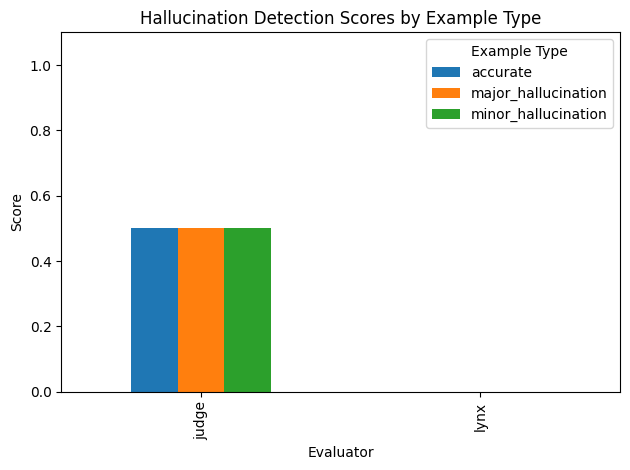

<Figure size 1000x600 with 0 Axes>

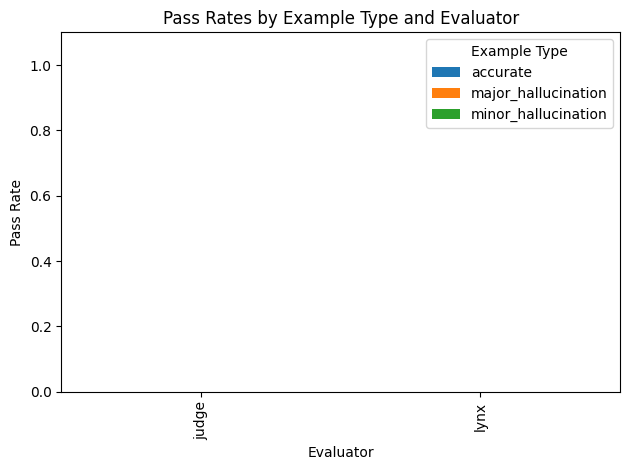


Evaluator agreement rate: 100.00%


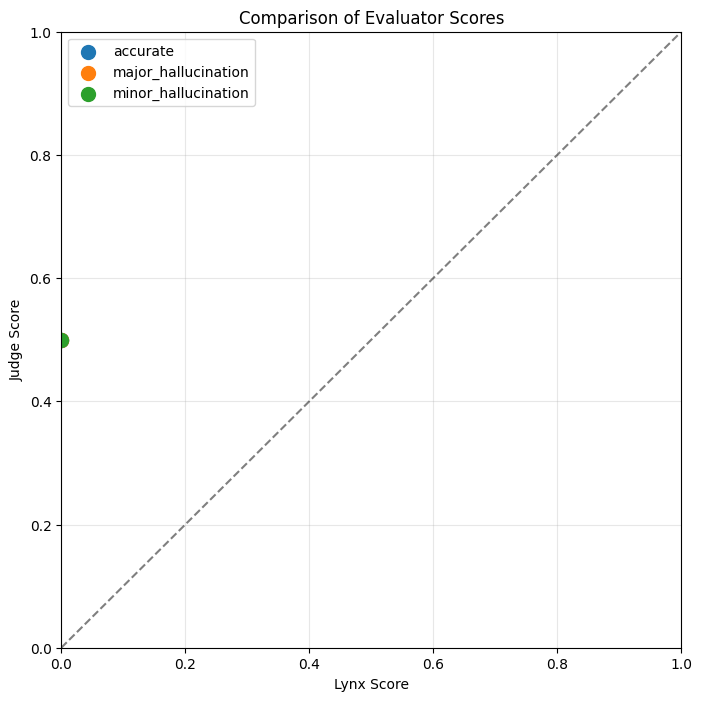

In [6]:
# For Jupyter Notebook
import pandas as pd
import matplotlib.pyplot as plt
from patronus.experiments import run_experiment
from patronus.evals import RemoteEvaluator

# Create a dataset with 5 examples for hallucination detection
dataset = [
    {
        "task_input": "What is the capital of France?",
        "task_context": "France is a country in Western Europe. Its capital is Paris.",
        "task_output": "The capital of France is Paris, which is known as the City of Light.",
        "tags": {"example_type": "accurate"}
    },
    {
        "task_input": "What is the population of Tokyo?",
        "task_context": "Tokyo is the capital of Japan. Its metropolitan area has a population of approximately 37 million people.",
        "task_output": "Tokyo's population is about 14 million people in the city proper and around 37 million in the metropolitan area.",
        "tags": {"example_type": "accurate"}
    },
    {
        "task_input": "Who invented the telephone?",
        "task_context": "Alexander Graham Bell is credited with patenting the first practical telephone in 1876.",
        "task_output": "The telephone was invented by Alexander Graham Bell in 1876, though Antonio Meucci developed a voice communication device in 1871.",
        "tags": {"example_type": "minor_hallucination"}
    },
    {
        "task_input": "What is the tallest mountain in Africa?",
        "task_context": "Mount Kilimanjaro, located in Tanzania, is the tallest mountain in Africa at 5,895 meters (19,341 feet) above sea level.",
        "task_output": "Mount Everest is the tallest mountain in Africa, standing at 8,848 meters above sea level.",
        "tags": {"example_type": "major_hallucination"}
    },
    {
        "task_input": "Who wrote the novel Moby Dick?",
        "task_context": "Moby Dick is a novel written by American author Herman Melville, published in 1851.",
        "task_output": "Moby Dick was written by Ernest Hemingway in the early 20th century. It tells the story of Captain Ahab's quest for revenge against a giant white whale.",
        "tags": {"example_type": "major_hallucination"}
    }
]

# Setup the experiment with two hallucination evaluators
# Note: In Jupyter notebooks, you need to await this call
experiment = await run_experiment(
    dataset=dataset,
    task=None,  # No task function since we already have outputs
    evaluators=[
        RemoteEvaluator("lynx", "patronus:hallucination"),
        RemoteEvaluator("judge", "patronus:detect-hallucination-missing-info")
    ],
    tags={"experiment_type": "hallucination_detection"}
)

# Get the results as a DataFrame
df = experiment.to_dataframe()

# Basic filtering and analysis
# Filter by evaluator
lynx_results = df[df["evaluator_id"] == "lynx"]
judge_results = df[df["evaluator_id"] == "judge"]

# Calculate overall statistics
print("=== Hallucination Detection Results ===")
lynx_pass_rate = lynx_results["eval.pass"].mean()
judge_pass_rate = judge_results["eval.pass"].mean()
print(f"Lynx pass rate: {lynx_pass_rate:.2%}")
print(f"Judge pass rate: {judge_pass_rate:.2%}")

# Advanced Analysis: Group by example type from tags
def get_example_type(tag_dict):
    """Extract example_type from tag dictionary"""
    if isinstance(tag_dict, dict):
        return tag_dict.get("example_type", "unknown")
    return "unknown"

# Add example_type as a column for easier analysis
df["example_type"] = df["tags"].apply(get_example_type)

# Group by evaluator and example type
by_type_evaluator = df.groupby(["evaluator_id", "example_type"])
pass_rates = by_type_evaluator["eval.pass"].mean().unstack()
scores = by_type_evaluator["eval.score"].mean().unstack()

print("\n=== Pass Rates by Example Type ===")
print(pass_rates)
print("\n=== Scores by Example Type ===")
print(scores)

# Create visualizations
plt.figure(figsize=(10, 6))
scores.plot(kind="bar")
plt.title("Hallucination Detection Scores by Example Type")
plt.xlabel("Evaluator")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.legend(title="Example Type")
plt.tight_layout()
plt.show()  # In Jupyter this will display the chart inline

# Create a bar chart comparing pass rates
plt.figure(figsize=(10, 6))
pass_rates.plot(kind="bar")
plt.title("Pass Rates by Example Type and Evaluator")
plt.xlabel("Evaluator")
plt.ylabel("Pass Rate")
plt.ylim(0, 1.1)
plt.legend(title="Example Type")
plt.tight_layout()
plt.show()

# Analyze evaluator agreement
# Create a pivot table to compare evaluator results for the same examples
pivot_df = df.pivot_table(
    index=["task_input", "example_type"],
    columns="evaluator_id",
    values="eval.pass"
)

# Calculate agreement rate
agreement = (pivot_df["lynx"] == pivot_df["judge"])
agreement_rate = agreement.mean()
print(f"\nEvaluator agreement rate: {agreement_rate:.2%}")

# Create a scatter plot comparing evaluator scores
plt.figure(figsize=(8, 8))
scatter_data = df.pivot_table(
    index="task_input",
    columns="evaluator_id",
    values="eval.score"
).reset_index()

# Add example type information for color coding
example_type_map = df.drop_duplicates("task_input").set_index("task_input")["example_type"]
scatter_data["example_type"] = scatter_data["task_input"].map(example_type_map)

# Plot points by example type
for example_type in scatter_data["example_type"].unique():
    subset = scatter_data[scatter_data["example_type"] == example_type]
    plt.scatter(
        subset["lynx"],
        subset["judge"],
        label=example_type,
        s=100
    )

# Add reference line for perfect correlation
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.xlabel("Lynx Score")
plt.ylabel("Judge Score")
plt.title("Comparison of Evaluator Scores")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.show()